# Wikipedia Data Project: List of Chemical Elements

**Student:** Ayman Berri  
**Course:** Wikipedia Data Project - Web Scraping  
**Objective:** Scrape and analyze data from Wikipedia's List of Chemical Elements.
This notebook includes data cleaning, analysis, 15 KPIs, and visualizations to support insights.


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
from io import StringIO


%matplotlib inline

In [3]:
URL = "https://en.wikipedia.org/wiki/List_of_chemical_elements"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

response = requests.get(URL, headers=headers)
response.raise_for_status()# stop if page not fetched

# Wrap HTML in StringIO
html_io = StringIO(response.text)

# Pass StringIO object to pandas
tables = pd.read_html(html_io)
print(f"Found {len(tables)} tables")


Found 9 tables


In [4]:
# Inspect first few tables to identify main element table
for i, t in enumerate(tables[:4]):
    print('TABLE', i, 'shape', t.shape)
    display(t.head(2))

TABLE 0 shape (118, 16)


vteList of chemical elements                                                 \
                             Z Sym.   Element Name origin [2][3] Group Period   
0                            1    H  Hydrogen                [k]     1      1   
1                            2   He    Helium                [l]    18      1   

                                                            \
     Block Atomic weight [a] (Da) Density [b][c] (⁠g/cm3⁠)   
0  s-block                 1.0080               0.00008988   
1  s-block                 4.0026                0.0001785   

                                             \
  Melting point[d] (K) Boiling point[e] (K)   
0                14.01                20.28   
1                 –[m]                 4.22   

                                                                \
  Specific heat capacity[f] (⁠J/g · K⁠) Electro­negativity [g]   
0                                14.304                   2.20   
1                                 5.193                      –   

                                                                
  Abundance in Earth's crust[h] (⁠mg/kg⁠)   Origin[i] Phase[j]  
0                                    1400  primordial      gas  
1                                   0.008  primordial      gas

TABLE 1 shape (11, 33)


,vtePeriodic table,vtePeriodic table.1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,10,11,12,13,14,15,16,17,18


TABLE 2 shape (8, 33)


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,10,11,12,13,14,15,16,17,18
1,1.0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,He


TABLE 3 shape (1, 4)


,0,1,2,3
0,s-block,f-block,d-block,p-block


I inspected the first few tables on the page and confirmed that tables[0] contains the full list of chemical elements. Other tables are metadata or periodic table layouts, so we will use only this table.

In [5]:
# Once you know which table is the main one, copy it
df = tables[0].copy()  # Change index if needed
df.columns = [c[1] if isinstance(c, tuple) else c for c in df.columns] # to print clean column names.
df.head()

,Z,Sym.,Element,Name origin [2][3],Group,Period,Block,Atomic weight [a] (Da),Density [b][c] (⁠g/cm3⁠),Melting point[d] (K),Boiling point[e] (K),Specific heat capacity[f] (⁠J/g · K⁠),Electro­negativity [g],Abundance in Earth's crust[h] (⁠mg/kg⁠),Origin[i],Phase[j]
0,1,H,Hydrogen,[k],1,1,s-block,1.0080,0.00008988,14.01,20.28,14.304,2.20,1400,primordial,gas
1,2,He,Helium,[l],18,1,s-block,4.0026,0.0001785,–[m],4.22,5.193,–,0.008,primordial,gas
2,3,Li,Lithium,[n],1,2,s-block,6.94,0.534,453.69,1560,3.582,0.98,20,primordial,solid
3,4,Be,Beryllium,[o],2,2,s-block,9.0122,1.85,1560,2742,1.825,1.57,2.8,primordial,solid
4,5,B,Boron,[p],13,2,p-block,10.81,2.34,2349,4200,1.026,2.04,10,primordial,solid


Functions to clean numeric columns and remove bracket references/footnotes. (Just functions, used later)

In [6]:

def strip_refs(x):
    """Remove bracket references and footnotes from strings."""
    if pd.isna(x):
        return x
    x = re.sub(r'\[.*?\]', '', str(x))
    x = re.sub(r'†', '', x)
    return x.strip()

def to_numeric_clean(s):
    """Convert messy numeric strings to floats, handling ranges and parentheses."""
    if pd.isna(s):
        return np.nan
    s = strip_refs(s).replace(',', '')
    s = re.sub(r'\(.*?\)', '', s).strip()
    if '–' in s or '-' in s:
        parts = [p for p in re.split(r'–|-', s) if p.strip()]
        try:
            nums = [float(p) for p in parts]
            return float(np.mean(nums))
        except:
            return np.nan
    try:
        return float(s)
    except:
        return np.nan


  
Clean string columns by stripping references from all string/object columns for readability

In [7]:
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype(str).apply(strip_refs)

Convert messy numeric columns to proper floats for calculations

In [8]:
mapping = {
    'Atomic weight': 'atomic_weight',
    'Density': 'density_g_cm3',
    'Melting point': 'melting_point_K',
    'Boiling point': 'boiling_point_K',
    'Specific heat capacity': 'specific_heat_J_gK',
    'Electro': 'electronegativity',
    "Abundance in Earth": 'abundance_mg_per_kg'
}

for wiki_col, new_col in mapping.items():
    matches = [c for c in df.columns if wiki_col.lower() in c.lower()]
    if matches:
        col = matches[0]
        df[new_col] = df[col].apply(to_numeric_clean)
        print(f"✅ Cleaned '{col}' → '{new_col}' (numeric values)")
    else:
        print(f"⚠️ Column containing '{wiki_col}' not found, skipping.")

print("\n  Numeric columns are ready for analysis.")


✅ Cleaned 'Atomic weight [a] (Da)' → 'atomic_weight' (numeric values)
✅ Cleaned 'Density [b][c] (⁠g/cm3⁠)' → 'density_g_cm3' (numeric values)
✅ Cleaned 'Melting point[d] (K)' → 'melting_point_K' (numeric values)
✅ Cleaned 'Boiling point[e] (K)' → 'boiling_point_K' (numeric values)
✅ Cleaned 'Specific heat capacity[f] (⁠J/g · K⁠)' → 'specific_heat_J_gK' (numeric values)
✅ Cleaned 'Electro­negativity [g]' → 'electronegativity' (numeric values)
✅ Cleaned 'Abundance in Earth's crust[h] (⁠mg/kg⁠)' → 'abundance_mg_per_kg' (numeric values)

  Numeric columns are ready for analysis.


C:\Users\temps\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\temps\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\temps\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\temps\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in sca

Save cleaned dataset to Excel

In [9]:
# quick overview of cleaned dataset before saving
df.info()
df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Z                                        118 non-null    int64  
 1   Sym.                                     118 non-null    object 
 2   Element                                  118 non-null    object 
 3   Name origin [2][3]                       118 non-null    object 
 4   Group                                    118 non-null    object 
 5   Period                                   118 non-null    int64  
 6   Block                                    118 non-null    object 
 7   Atomic weight [a] (Da)                   118 non-null    object 
 8   Density [b][c] (⁠g/cm3⁠)                 118 non-null    object 
 9   Melting point[d] (K)                     118 non-null    object 
 10  Boiling point[e] (K)                     118 non-n

,Z,Sym.,Element,Name origin [2][3],Group,Period,Block,Atomic weight [a] (Da),Density [b][c] (⁠g/cm3⁠),Melting point[d] (K),...,Abundance in Earth's crust[h] (⁠mg/kg⁠),Origin[i],Phase[j],atomic_weight,density_g_cm3,melting_point_K,boiling_point_K,specific_heat_J_gK,electronegativity,abundance_mg_per_kg
0,1,H,Hydrogen,,1,1,s-block,1.0080,0.00008988,14.01,...,1400,primordial,gas,1.0080,0.000090,14.01,20.28,14.304,2.20,1400.000
1,2,He,Helium,,18,1,s-block,4.0026,0.0001785,–,...,0.008,primordial,gas,4.0026,0.000179,NaN,4.22,5.193,NaN,0.008
2,3,Li,Lithium,,1,2,s-block,6.94,0.534,453.69,...,20,primordial,solid,6.9400,0.534000,453.69,1560.00,3.582,0.98,20.000


In [10]:
df.to_excel("cleaned_elements.xlsx", index=False)
print("Saved cleaned_elements.xlsx")

Saved cleaned_elements.xlsx


# Category 1: Structure of the Periodic Table (foundation)

## KPI 1: Count of elements in each block (s, p, d, f) to see which block contains the most elements

Purpose / Insight:  
This KPI shows how many chemical elements belong to each block of the periodic table (s, p, d, f). It helps us quickly understand which blocks are most populated and identify patterns in element distribution.


Block
d-block    40
p-block    36
f-block    28
s-block    14
Name: count, dtype: int64


<Axes: title={'center': 'Count of Elements by Block'}, xlabel='Block', ylabel='Count'>

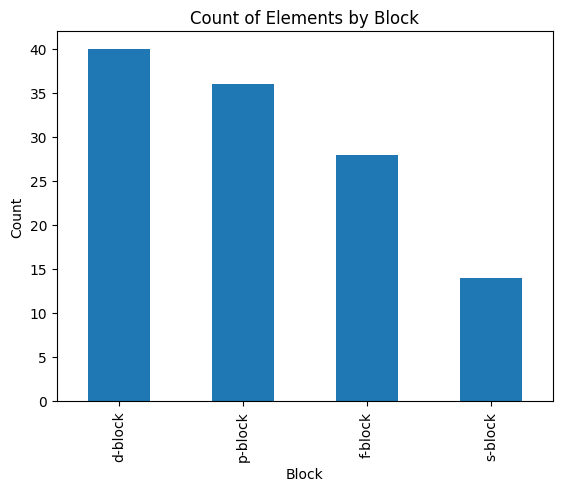

In [11]:
block_counts = df['Block'].value_counts()
print(block_counts)
block_counts.plot(kind='bar', title='Count of Elements by Block', xlabel='Block', ylabel='Count')

## KPI 2: Count of elements by natural phase (solid, liquid, gas)


Phase[j]
solid            84
unknown phase    21
gas              11
liquid            2
Name: count, dtype: int64


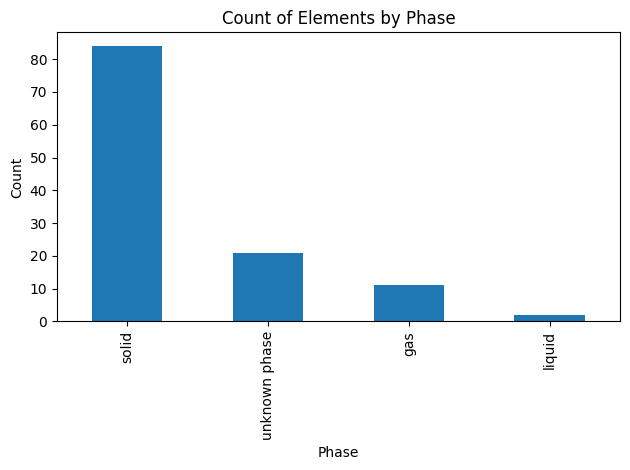

In [12]:
phase_counts = df['Phase[j]'].value_counts()
print(phase_counts)

phase_counts.plot(kind='bar', title='Count of Elements by Phase', xlabel='Phase', ylabel='Count')
plt.tight_layout()
plt.show()


## KPI 3: Count of Elements by Group

Purpose / Insight:  
This KPI shows how many elements are in each group (column) of the periodic table. Groups contain elements with similar properties — like how reactive they are or how they bond.

You’ll notice that transition metals (Groups 3–12) dominate the chart, while Groups 1–2 have only a few but very reactive metals. It’s a simple way to see how the periodic table is organized and where most elements belong.

Group
1                  7
10                 4
11                 4
12                 4
13                 6
14                 6
15                 6
16                 6
17                 6
18                 7
2                  6
3                  4
4                  4
5                  4
6                  4
7                  4
8                  4
9                  4
f-block groups    28
Name: count, dtype: int64


<Axes: title={'center': 'Count of Elements by Group'}, xlabel='Group', ylabel='Count'>

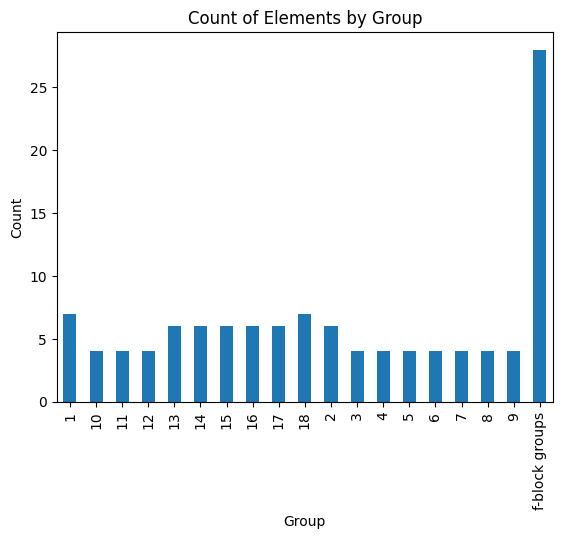

In [13]:
# See which periodic groups (columns) contain the most elements
group_counts = df['Group'].value_counts().sort_index()
print(group_counts)
group_counts.plot(kind='bar', title='Count of Elements by Group', xlabel='Group', ylabel='Count')


# Category 2: Atomic and Physical Properties

## KPI 4: Average Atomic Weight by Period

Purpose / Insight:  
This KPI calculates the average atomic weight for each period (periods are the horizontal rows.) of the periodic table. It helps us see how atomic weight generally increases as we move down the table, highlighting trends in element mass across periods.

Period
1      2.505300
2     13.494650
3     30.099500
4     60.678889
5    106.696118
6    171.060714
7    233.703333
Name: atomic_weight, dtype: float64


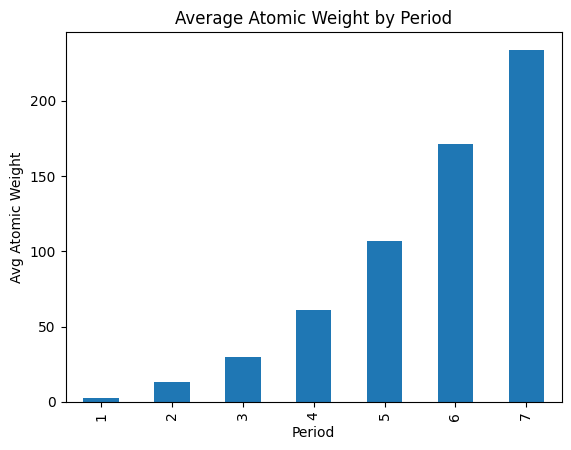

In [14]:
if 'Period' in df.columns:
    period_avg_weight = df.groupby('Period')['atomic_weight'].mean()
    print(period_avg_weight)
    period_avg_weight.plot(kind='bar', title='Average Atomic Weight by Period', xlabel='Period', ylabel='Avg Atomic Weight')

## KPI 5: Heaviest Elements

Purpose/Insight:  
Here we highlight the 10 heaviest elements in the periodic table. Uranium, Thorium, and Plutonium are some examples—these are so massive that just a small amount can be surprisingly dense and radioactive! This makes it easier to visualize which elements pack the most mass per atom.

         Element  atomic_weight
91       Uranium         238.03
89       Thorium         232.04
90  Protactinium         231.04
82       Bismuth         208.98
81          Lead         207.20
80      Thallium         204.38
79       Mercury         200.59
78          Gold         196.97
77      Platinum         195.08
76       Iridium         192.22


<Axes: title={'center': 'Top 10 Heaviest Elements'}, ylabel='Element'>

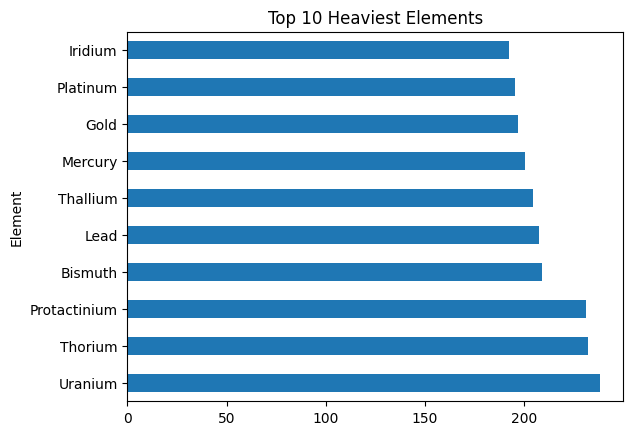

In [15]:
top10_heavy = df[['Element', 'atomic_weight']].dropna().sort_values('atomic_weight', ascending=False).head(10)
print(top10_heavy)
top10_heavy.plot(kind='barh', x='Element', y='atomic_weight', title='Top 10 Heaviest Elements', legend=False)


## KPI 6: Relationship Between Density and Atomic Weight

Purpose/Insight:  
Heavier atoms tend to be denser, _but not always!_ This scatter plot shows how atomic weight and density relate. You’ll spot outliers like **Osmium** and **Iridium**, some of the densest substances on Earth.

In [16]:
import plotly.express as px

fig = px.scatter(
    df,
    x='atomic_weight',
    y='density_g_cm3',
    hover_data=['Element'],
    title='Atomic Weight vs Density of Elements',
    labels={'atomic_weight': 'Atomic Weight (Da)', 'density_g_cm3': 'Density (g/cm³)'},
    color='Block'
)
fig.show()


## KPI 7: Densest Elements

Purpose / Insight:  
This KPI highlights the densest elements in the periodic table. Density is important in materials science, engineering, and chemistry, as it affects how elements are used in construction, electronics, or industrial applications.

      Element  density_g_cm3
75     Osmium          22.59
76    Iridium          22.56
77   Platinum          21.45
74    Rhenium          21.02
92  Neptunium          20.45
93  Plutonium          19.85
78       Gold          19.30
73   Tungsten          19.25
91    Uranium          19.10
72   Tantalum          16.69


<Axes: title={'center': 'Top 10 Densest Elements'}, ylabel='Element'>

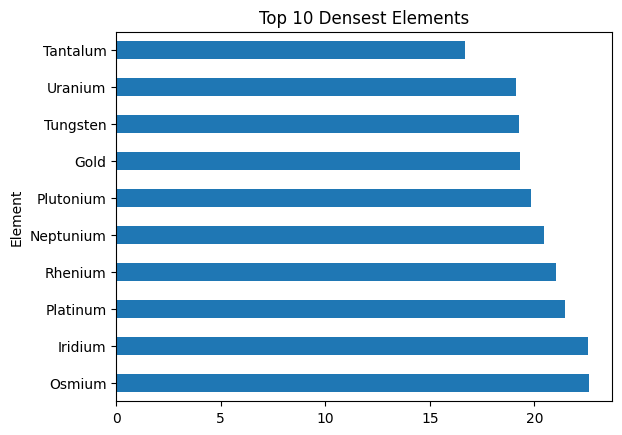

In [17]:
top10_density = df[['Element', 'density_g_cm3']].dropna().sort_values('density_g_cm3', ascending=False).head(10)
print(top10_density)
top10_density.plot(kind='barh', x='Element', y='density_g_cm3', title='Top 10 Densest Elements', legend=False)

## KPI 8: Elements with the widest Liquid Range

Purpose/Insight:  
This chart highlights the 10 elements with the widest temperature range between melting and boiling points (in Kelvin). Elements with a large liquid range stay liquid over a broad range of temperatures, which can be useful for industrial processes, high-temperature applications, or understanding extreme element behavior.  
Elements like **Neptuniu** (3356 K), **Uranium** (2998.7 K), and **Thorium** (2946 K) remain liquid over extremely broad temperature ranges, making them interesting for high-temperature industrial applications or scientific studies of molten metals.


         Element  liquid_range
92     Neptunium        3356.0
91       Uranium        2998.7
89       Thorium        2946.0
57        Cerium        2648.0
93     Plutonium        2588.5
58  Praseodymium        2585.0
39     Zirconium        2554.0
56     Lanthanum        2544.0
73      Tungsten        2508.0
90  Protactinium        2459.0


<Axes: title={'center': 'Top 10 Liquid Range Elements'}, ylabel='Element'>

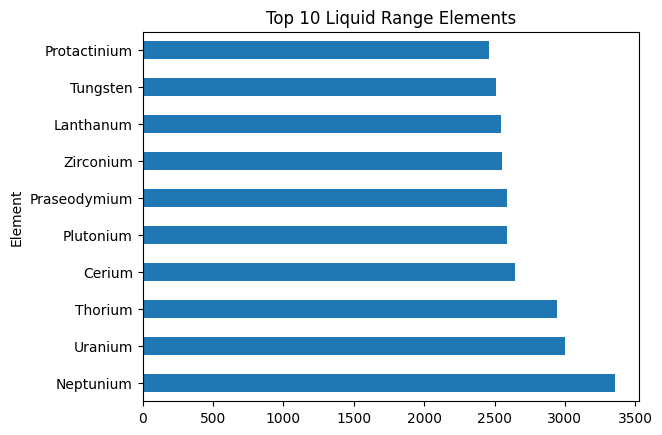

In [18]:
df['liquid_range'] = df['boiling_point_K'] - df['melting_point_K']
top10_liquid_range = df[['Element','liquid_range']].dropna().sort_values('liquid_range', ascending=False).head(10)
print(top10_liquid_range)
top10_liquid_range.plot(kind='barh', x='Element', y='liquid_range', title='Top 10 Liquid Range Elements', legend=False)

# Category 3: Thermal and Energy Behavior

## KPI 9: Melting vs Boiling Point

Purpose / Insight:  
This KPI shows the relationship between an element’s melting point and boiling point, which helps understand phase changes and thermal stability. It’s useful in materials science, chemistry, and engineering to predict how elements behave under heat.

In [19]:
import plotly.express as px # Trying plotly for the first time

fig = px.scatter(df, x='melting_point_K', y='boiling_point_K', hover_name='Element',
                 title='Melting vs Boiling Point')
fig.show()


## KPI 10: Elements with the highest Specific Heat Capacity

Purpose/Insight:  
    Specific heat tells us how much energy an element can absorb before it gets hotter.  
    Listing the top 10 shows which elements are “heat sponges” and can influence things like cookware, engineering, or energy storage.  
Note: J/g·K → Joules per gram per Kelvin

      Element  specific_heat_J_gK
0    Hydrogen              14.304
1      Helium               5.193
2     Lithium               3.582
3   Beryllium               1.825
10     Sodium               1.228
6    Nitrogen               1.040
9        Neon               1.030
4       Boron               1.026
11  Magnesium               1.023
7      Oxygen               0.918


<Axes: title={'center': 'Top 10 Specific Heat Capacities'}, ylabel='Element'>

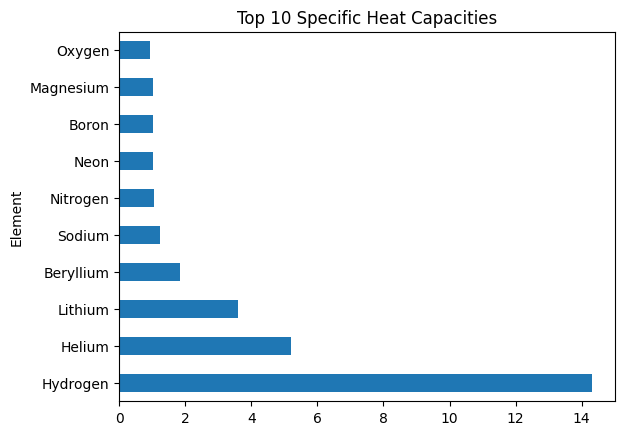

In [20]:
top10_shc = df[['Element', 'specific_heat_J_gK']].dropna().sort_values('specific_heat_J_gK', ascending=False).head(10)
print(top10_shc)
top10_shc.plot(kind='barh', x='Element', y='specific_heat_J_gK', title='Top 10 Specific Heat Capacities', legend=False)

# Category 4: Natural Abundance and Availability

## KPI 11: Abundance in Earth's Crust

Purpose/Insight:  
This chart shows the 10 most common elements in the Earth's crust, measured in milligrams per kilogram (mg/kg). It helps us understand which elements are abundant and which are rare, giving insight into natural resources and why some materials are easier or harder to obtain.

      Element  abundance_mg_per_kg
7      Oxygen             461000.0
13    Silicon             282000.0
12  Aluminium              82300.0
25       Iron              56300.0
19    Calcium              41500.0
10     Sodium              23600.0
11  Magnesium              23300.0
18  Potassium              20900.0
21   Titanium               5650.0
0    Hydrogen               1400.0


<Axes: title={'center': "Top 10 Elements by Earth's Crust Abundance"}, ylabel='abundance_mg_per_kg'>

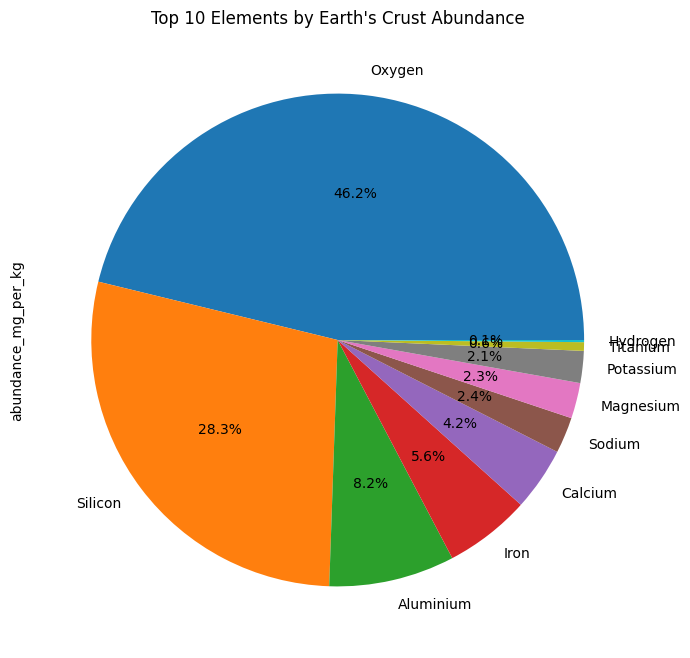

In [21]:
top20_abund = df[['Element', 'abundance_mg_per_kg']].dropna().sort_values(
    'abundance_mg_per_kg', ascending=False
).head(10)

print(top20_abund)

# Create a pie chart
top20_abund.set_index('Element')['abundance_mg_per_kg'].plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(8, 8),
    title="Top 10 Elements by Earth's Crust Abundance"
)


## KPI 12: Rarest Naturally Occurring Elements

Purpose/Insight:  
Highlights elements like gold, platinum, and rhodium — rare, valuable, and key to modern tech.

      Element  abundance_mg_per_kg
43  Ruthenium                0.001
51  Tellurium                0.001
44    Rhodium                0.001
76    Iridium                0.001
75     Osmium                0.002
78       Gold                0.004
77   Platinum                0.005
9        Neon                0.005
1      Helium                0.008
82    Bismuth                0.009


<Axes: title={'center': 'Rarest Naturally Occurring Elements'}, ylabel='Element'>

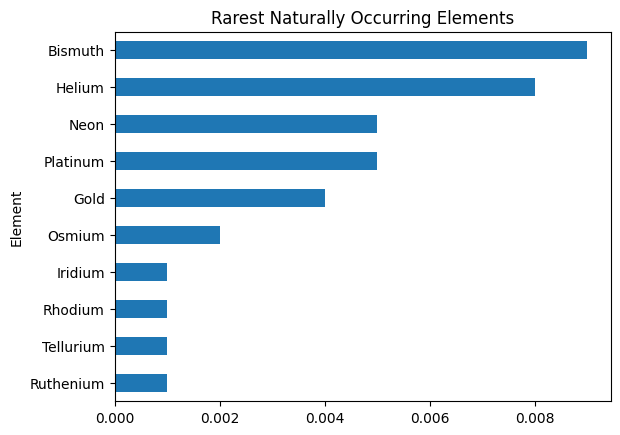

In [28]:
# Find elements with lowest abundance
rare_elements = df[['Element', 'abundance_mg_per_kg']].dropna().sort_values('abundance_mg_per_kg', ascending=True).head(10)
print(rare_elements)
rare_elements.plot(kind='barh', x='Element', y='abundance_mg_per_kg', title='Rarest Naturally Occurring Elements', legend=False)


# Category 5: Chemical Reactivity and Bonding Behavior

## KPI 13: Electronegativity by Group

Purpose/Indsight:  
Electronegativity measures how strongly an element attracts electrons.  
By comparing averages across groups, we can see clear patterns in chemical behavior, such as why some elements bond easily or react more strongly than others.

Group
1                 1.047143
10                2.130000
11                2.123333
12                1.780000
13                1.772000
14                2.058000
15                2.296000
16                2.534000
17                2.992000
18                2.600000
2                 1.103333
3                 1.287500
4                 1.390000
5                 1.576667
6                 2.060000
7                 1.783333
8                 2.076667
9                 2.120000
f-block groups    1.234286
Name: Electro­negativity [g], dtype: float64


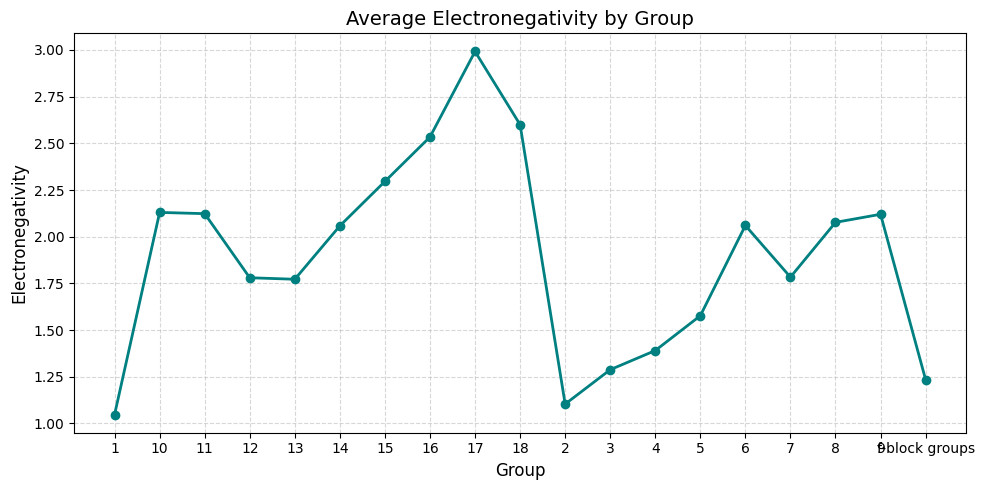

In [30]:
# Clean the Electronegativity column
df['Electro­negativity [g]'] = (
    df['Electro­negativity [g]']
    .astype(str)
    .str.extract(r'([\d\.]+)')[0]  # extract only digits and decimals
    .astype(float)
)

# Group and sort
if 'Group' in df.columns:
    elec_group = (
        df.groupby('Group')['Electro­negativity [g]']
        .mean()
        .sort_index()
    )

    print(elec_group)

    # --- Visualization: Line Chart ---
    plt.figure(figsize=(10, 5))
    plt.plot(elec_group.index, elec_group.values, marker='o', color='teal', linewidth=2)
    plt.title('Average Electronegativity by Group', fontsize=14)
    plt.xlabel('Group', fontsize=12)
    plt.ylabel('Electronegativity', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## KPI 14: Elements with the Lowest Melting Points

Purpose / Insight:  
This KPI shows the 10 elements that melt at the lowest temperatures, highlighting gases and soft metals that are liquid or melt easily near room temperature — like Mercury, Gallium, and Cesium.  
These elements are fascinating because they challenge our expectations of “solid metals” and are used in thermometers, electronics, and cooling systems.

     Element  melting_point_K
0   Hydrogen            14.01
9       Neon            24.56
8   Fluorine            53.53
7     Oxygen            54.36
6   Nitrogen            63.15
17     Argon            83.80
35   Krypton           115.79
53     Xenon           161.40
16  Chlorine           171.60
85     Radon           202.00


<Axes: title={'center': 'Top 10 Elements with Lowest Melting Points (K)'}, ylabel='Element'>

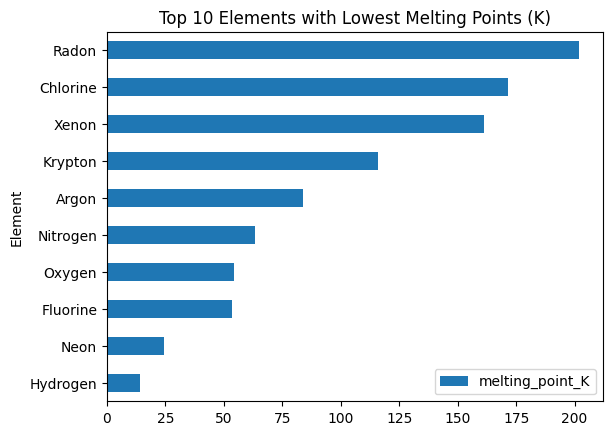

In [24]:
low10_melting = df[['Element', 'melting_point_K']].dropna().sort_values('melting_point_K', ascending=True).head(10)
print(low10_melting)
low10_melting.plot(kind='barh', x='Element', y='melting_point_K', title='Top 10 Elements with Lowest Melting Points (K)', legend=True)


## KPI 15: Lightest Elements by Atomic Weight

Purpose / Insight:   
This KPI lists the 10 lightest elements, showing those that make up much of our atmosphere and life — like Hydrogen, Helium, Carbon, Nitrogen, and Oxygen.  
These lightweight elements are crucial to life, stars, and the air we breathe, forming the basis of organic chemistry and energy reactions.

     Element  atomic_weight
0   Hydrogen         1.0080
1     Helium         4.0026
2    Lithium         6.9400
3  Beryllium         9.0122
4      Boron        10.8100
5     Carbon        12.0110
6   Nitrogen        14.0070
7     Oxygen        15.9990
8   Fluorine        18.9980
9       Neon        20.1800


<Axes: title={'center': 'Top 10 Lightest Elements'}, ylabel='Element'>

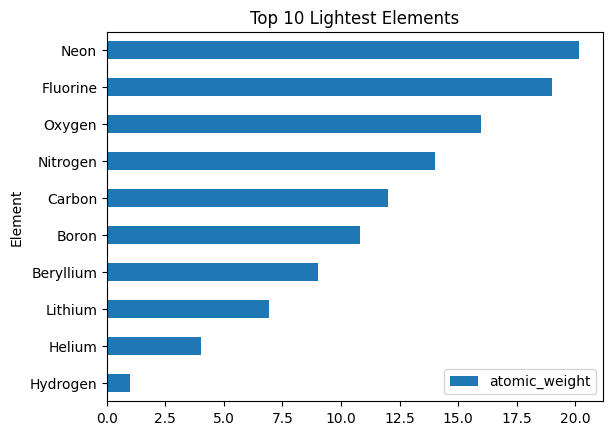

In [25]:
light10 = df[['Element', 'atomic_weight']].dropna().sort_values('atomic_weight', ascending=True).head(10)
print(light10)
light10.plot(kind='barh', x='Element', y='atomic_weight', title='Top 10 Lightest Elements', legend=True)


# Conclusion
- Successfully scraped and cleaned the chemical elements data from Wikipedia.  
- Computed 15 key KPIs with simple visualizations.  
- Saved cleaned dataset to `cleaned_elements.xlsx` for reference.  
- These charts and insights can now be used in the PowerPoint presentation.
